In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import distributions as dist
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms as tr
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from pprint import pprint
from inpainting.custom_layers import Reshape
from inpainting.losses import nll_masked_batch_loss, r2_masked_batch_loss, r2_total_batch_loss
from inpainting.inpainters.digits import DigitsLinearInpainter

In [4]:
from inpainting.datasets.digits import train_val_datasets
from inpainting.visualizations.digits import digit_with_mask as vis_digit_mask
from inpainting.training import train_inpainter
from inpainting.utils import classifier_experiment, inpainted

In [5]:
torch.cuda.is_available()

False

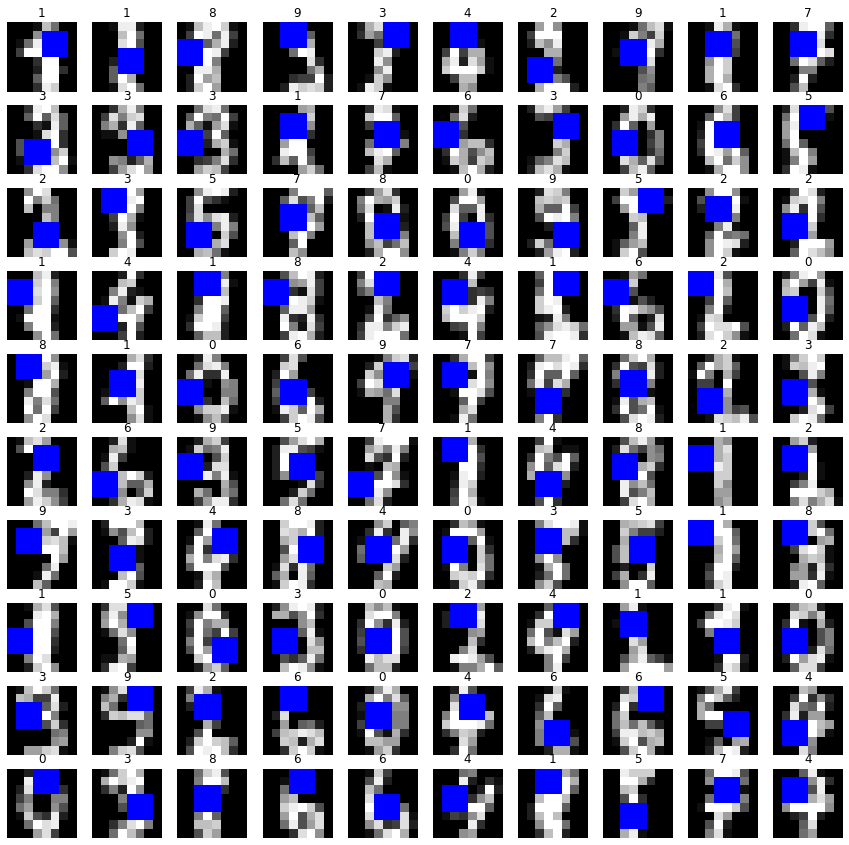

In [6]:
ds_train, ds_val = train_val_datasets(3)

fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i in range(100):
    x_j, y = ds_train[i]
    x = x_j[:-1]
    j = x_j[-1:]
    ax = axes[i // 10, i%10]
    ax.set_title(f"{y}")
    vis_digit_mask(x, j,ax)

In [7]:
X_J_train, y_train = ds_train.tensors #[t.cpu().detach().numpy() for t in ds_train.tensors]
X_J_val, y_val = ds_val.tensors #[t.cpu().detach().numpy() for t in ds_val.tensors]

X_train = X_J_train[:, :-1].squeeze()
classifier = MLPClassifier((100, 200, 10,), learning_rate_init=4e-3, max_iter=1000).fit(X_train, y_train)


In [8]:
batch_size=16
dl_train = DataLoader(ds_train, batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size, shuffle=True)

In [9]:
m_std = lambda x, j, p, m, a, d: m.std(dim=0).mean()

In [10]:
inpainter = DigitsLinearInpainter(bias=True, n_hidden_layers=3)
opt = optim.Adam(inpainter.parameters(), lr=4e-4)
# opt = optim.SGD(inpainter.parameters(), lr=1e-4)
n_epochs = 200
history = train_inpainter(
    inpainter, 
    dl_train, 
    dl_val, 
    opt, 
    loss_fn = nll_masked_batch_loss, 
    n_epochs=n_epochs,
    losses_to_log=dict(nll=nll_masked_batch_loss, r2_masked=r2_masked_batch_loss, m_std=m_std)
)

100%|██████████| 200/200 [17:14<00:00,  5.17s/it]


In [11]:
history[-1]["losses"]["objective"]

{'train': -5.0944333, 'val': 1.926707}

In [12]:
history_tmp = history
history = history

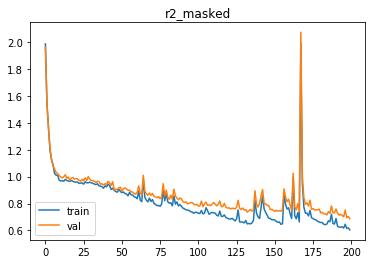

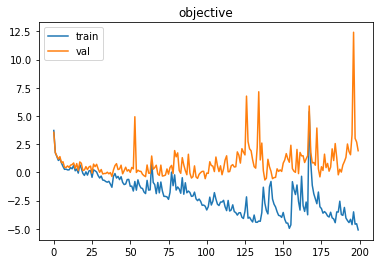

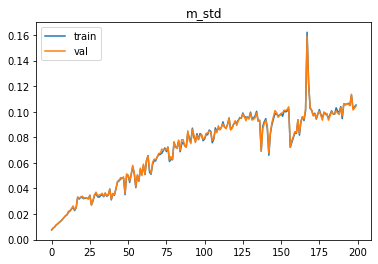

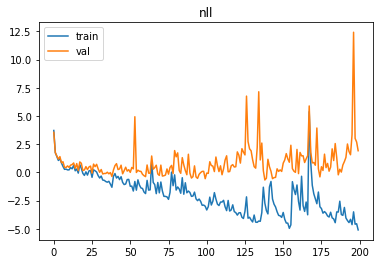

In [13]:
for loss_name in set(history[0]["losses"].keys()):
    for fold in ["train", "val"]:
        
        plt.plot(
            list(range(len(history))),
            [h["losses"][loss_name][fold] for h in history],
            label=fold
        )
    plt.title(loss_name)
    plt.legend()
    plt.show()

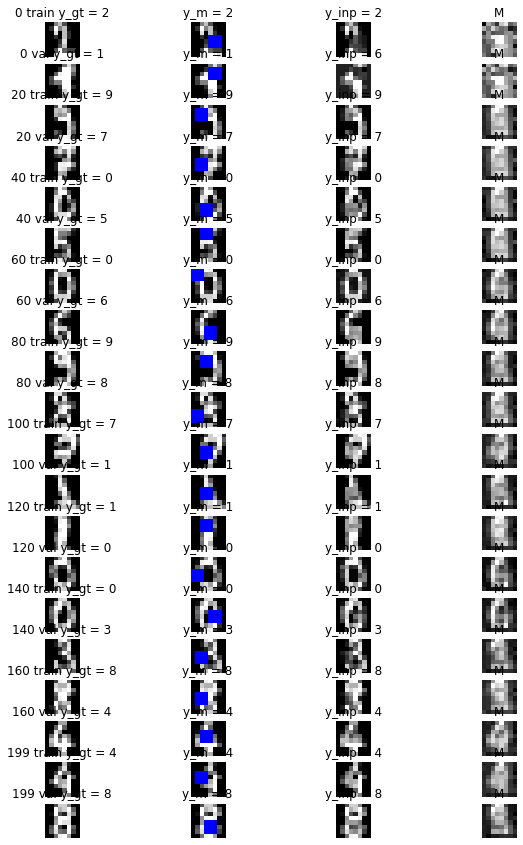

In [14]:


skip = 20

fig, axes = plt.subplots(
    int(np.ceil(len(history) / skip)* 2), 
    4,
    figsize=(10,15)
)


for e, h in enumerate(history):
    if e % skip !=0 and e != (len(history) -1):
        continue
    
    for ax_no, fold in [(0,"train"), (1,"val")]:
        
        # 0 - gt
        x, j, p, m, a, d, y = [t[0] for t in  h["sample_results"][fold]]
        row_no = (e // skip)*2 + ax_no
        ax = axes[row_no, 0]
        ax.imshow(x.reshape(8,8), cmap="gray")
        ax.axis("off")
        ax.set_title(f"{e} {fold} y_gt = {y}")
        
        # 1 - masked
        ax = axes[row_no, 1]
        vis_digit_mask(x, j, ax)
        y_masked_pred = classifier.predict(x)[0]
        ax.set_title(f"y_m = {y_masked_pred}")
        
        # 2 - inpainted
        ax = axes[row_no, 2]
        x_inp = x.copy()
        x_inp[:, j==0] = m[:, j==0]

        
        y_inp_pred = classifier.predict(x_inp)[0]

        ax.imshow(x_inp.reshape(8,8), cmap="gray")
        ax.axis("off")
        ax.set_title(f"y_inp = {y_inp_pred}")
        
        # 3 - M
        ax = axes[row_no, 3]
        ax.imshow(m[0].reshape(8,8), cmap="gray")
        ax.axis("off")
        ax.set_title(f"M")
        